# 目标检测数据集
- 使用现有的目标检测数据集,来在图像上画出真正的边框.

In [1]:
import torch
import torchvision
import numpy as np
import cv2 as cv
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

In [2]:
path_train = "C:/Users/CCU6/Desktop/数据集/banana-detection/banana-detection/bananas_train"
path_validtion = "C:/Users/CCU6/Desktop/数据集/banana-detection/banana-detection/bananas_val"

## 1 读取数据集

In [3]:
def read_banana_data(is_train = True, path_train = path_train, path_val = path_validtion):
    if is_train:
        image_path = path_train
        csv_path = path_train + "/label.csv"
        csv_data = pd.read_csv(csv_path)
    else:
        image_path = path_val
        csv_path = path_val + "/label.csv"
        csv_data = pd.read_csv(csv_path)
    images, targets = [], []
    for image_index, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(image_path + "/images/" + target[0]))
        targets.append(list(target[1:]))
    
    return images, torch.tensor(targets)

In [4]:
image, target = read_banana_data()

In [5]:
target

tensor([[  0, 104,  20, 143,  58],
        [  0,  68, 175, 118, 223],
        [  0, 163, 173, 218, 239],
        ...,
        [  0,  47,  54,  86, 109],
        [  0,  43, 125,  90, 166],
        [  0, 191,  99, 249, 152]])

## 1.1 构建自己的Dataset类

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, is_train = True, transforms = None):
        super().__init__()
        self.images, self.labels = read_banana_data(is_train = is_train)
        
    def __getitem__(self, index):
        return self.images[index], self.labels[index]
    
    def __len__(self):
        return len(self.images)


In [7]:
all_data = MyDataset(True)

In [8]:
len(all_data), all_data[0]

(1000,
 (tensor([[[217, 223, 220,  ...,  28,  15,  28],
           [206, 207, 215,  ...,  41,  18,  29],
           [191, 197, 210,  ...,  54,  28,  18],
           ...,
           [205, 211, 207,  ...,  44,  50,  75],
           [201, 202, 203,  ...,  50,  55,  69],
           [198, 195, 198,  ...,  55,  59,  68]],
  
          [[214, 220, 219,  ...,  23,  10,  23],
           [203, 207, 214,  ...,  36,  13,  24],
           [191, 197, 210,  ...,  46,  23,  13],
           ...,
           [202, 208, 204,  ...,  45,  52,  77],
           [197, 199, 200,  ...,  52,  57,  72],
           [194, 191, 195,  ...,  57,  61,  71]],
  
          [[241, 249, 250,  ...,  19,   4,  17],
           [230, 233, 245,  ...,  32,   7,  18],
           [215, 223, 238,  ...,  43,  17,   7],
           ...,
           [221, 225, 221,  ...,  37,  39,  63],
           [214, 216, 217,  ...,  41,  43,  55],
           [209, 206, 212,  ...,  46,  47,  54]]], dtype=torch.uint8),
  tensor([  0, 104,  20, 143,  58

In [9]:
train = torch.utils.data.DataLoader(MyDataset(True), batch_size = 128, shuffle = True, num_workers = 0)
val = torch.utils.data.DataLoader(MyDataset(False), batch_size = 128, shuffle = True, num_workers = 0)

In [10]:
len(train), len(val)

(8, 1)

In [11]:
batch = next(iter(train))
batch[0].shape, batch[1][0:2]

(torch.Size([128, 3, 256, 256]),
 tensor([[  0,  47,  65, 102, 117],
         [  0, 104,  20, 143,  58]]))

### 1.3 显示图片

In [12]:
def show_image(imgs, num_rows, num_cols, titles = None):
    figsize = (10, 3)
    _, axes = plt.subplots(num_rows, num_cols, figsize = figsize, num = 1)
    axes = axes.flatten()
    for i, ax, img in zip(range(len(imgs)), axes, imgs):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        if titles:
            ax.set_title(titles[i])
    plt.show()
    return axes

### 1.4 画边框

In [16]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = plt.Rectangle(xy = (bbox[0], bbox[1]), width = bbox[2]-bbox[0], height = bbox[3]-bbox[1], 
                             fill = False, edgecolor = color, linewidth = 1)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

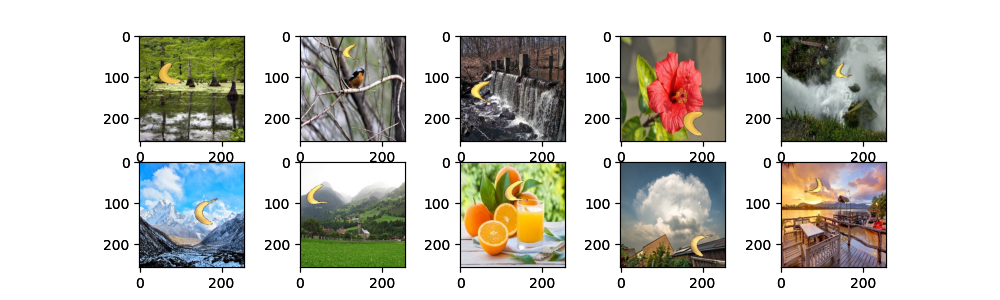

In [17]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1))
axes = show_image(imgs, 2, 5)
for ax, label in zip(axes, batch[1][0:10]):
    show_bboxes(ax, [label[1:5]], colors=['w'])

In [15]:
label

tensor([  0,  57,  39, 101,  74])